A [recent study](https://pubmed.ncbi.nlm.nih.gov/27400279/) from the [Segata Lab](http://segatalab.cibio.unitn.it/) analyzes human microbiome data obtained using shotgun metagenomic analysis.

"Shotgun metagenomic analysis of the human associated microbiome provides a rich set of microbial features for prediction and biomarker discovery in the context of human diseases and health conditions. However, the use of such high-resolution microbial features presents new challenges, and validated computational tools for learning tasks are lacking."

The dataset used in the study is available freely at [MetAML - Metagenomic prediction Analysis based on Machine Learning](https://github.com/SegataLab/metaml) and on [kaggle](https://www.kaggle.com/antaresnyc/metagenomics). 

The dataset gives abundances of different microbial species present in microbiome samples from healthy people and patients  with a variety of different diseases. The goal of the above mentioned study was to correctly predict whether a patient had a given disease or was healthy from the species abundance data for the patient's microbiome sample, after training on healthy samples and samples from patients with the given disease. 

In a practical setting, one may not have access to many samples from patients with a given disease and would want to be able to predict from a patient's microbiome data whether they have one of two possible diseases given only a few labeled examples for each of the two diseases. This problem belongs to a class of problems known as "Few-shot learning" studied in the Machine Learning Literature.

Our goal will be train a model to classify a given microbiome sample as having one of two previously unseen diseases (not present in the training set), from only a few labeled examples for each of the two diseases. I use a recent elegant and general algorithm known as [Model Agnostic Meta-Learning algorithm](https://arxiv.org/abs/1703.03400) to learn to classify the species abundance data into two unseen disease classes, given only 3 labeled examples, i.e. the 3-shot 2-way classification task. 

In the following, I classify species abundance samples into 'Obesity' vs 'Type 2 Diabetes' given only 3 labeled examples for each, and by training on the data for the remaining diseases. Guided by the performance comparison of different model architechtures on a similar task [studied here](https://www.nature.com/articles/s41598-019-46649-z), I use a single hidden layer Multi-Layer Perceptron with 128 neurons.

The model achieves an impressive performance comparable to the best previous results on this dataset, with an accuracy (> 80 %), an F1 score (> 0.8), an ROC AUC score (> 0.8), and a Confusion Matrix ~((8x, x),(x, 8x)).

It is worth noting that the validation and training data in this case have no disease classes in common, and that both are balanced, i.e. have equal numbers of samples for each disease.

Different seed choices lead to different choices of diseases for testing. 

I build on the previous notebooks using this [metagenomics dataset](https://www.kaggle.com/antaresnyc/metagenomics): 
* [sklasfeld/starter-metagenomics](https://www.kaggle.com/sklasfeld/starter-metagenomics)
* [antaresnyc/cirrhosis-classification/notebook](https://www.kaggle.com/antaresnyc/cirrhosis-classification/notebook)
* [tmathieu/feature-selection-to-predict-diabetes](https://www.kaggle.com/tmathieu/feature-selection-to-predict-diabetes)

I closely follow the excellent [MAML implementation by Oscar Knagg](https://github.com/oscarknagg/few-shot) and the Perceptron implementation [described here](https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb#scrollTo=C6gprB1sO7fy).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from pandas.api.types import is_numeric_dtype
from typing import List, Iterable, Callable, Tuple

from xgboost import XGBClassifier
import xgboost as xgb

import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score

# import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from plotnine import *

from tqdm import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from collections import OrderedDict
from typing import Dict, List, Callable, Union

import copy
import random
import time

SEED = 1729

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/metagenomics/markers2clades_DB.txt
/kaggle/input/metagenomics/abundance_stoolsubset.txt
/kaggle/input/metagenomics/abundance.txt
/kaggle/input/metagenomics/marker_presence.txt


# Importing Data and preparing it

In [2]:
def  file_to_dataframe(file):
    # this file is transposed of what we expect in a pandas dataframe
    # therefore we import the file and transpose it
    df = pd.read_csv(file,sep="\t",dtype=object,header=None).T

    # now we can set the header
    header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = header #set the header row as the df header

    return(df)

abundance_full_df = file_to_dataframe("/kaggle/input/metagenomics/abundance.txt")
abundance_stool_full_df = file_to_dataframe(
    "/kaggle/input/metagenomics/abundance_stoolsubset.txt")

The following verifies that the file abundance_stool_subset.txt contains a subset of the data in abundance.txt, as asserted in the [starter metagenomics notebook](https://www.kaggle.com/sklasfeld/starter-metagenomics)

In [3]:
abundance_subset_stool_cols_df = abundance_full_df.loc[
                                abundance_full_df.bodysite == 'stool']
stool_cols = abundance_stool_full_df.columns.to_numpy()
abundance_subset_stool_cols_df = abundance_subset_stool_cols_df[stool_cols]
unique_sample_ids = abundance_subset_stool_cols_df['sampleID'].unique()
unique_subject_ids = abundance_subset_stool_cols_df['subjectID'].unique() 
num_cols = abundance_stool_full_df.shape[1]
same_data = True
for sample_id in unique_sample_ids:
    abundance_stool_full_df_sample = abundance_stool_full_df.loc[
                                    abundance_stool_full_df.sampleID == sample_id]
    abundance_subset_stool_df_sample = abundance_subset_stool_cols_df.loc[
                            abundance_subset_stool_cols_df.sampleID == sample_id]
    unique_subject_ids = abundance_stool_full_df_sample['subjectID'].unique()
    for subject_id in unique_subject_ids:
        abundance_stool_full_df_data = abundance_stool_full_df_sample.loc[
                        abundance_stool_full_df_sample.subjectID == subject_id]
        abundance_subset_stool_data = abundance_subset_stool_df_sample.loc[
                        abundance_subset_stool_df_sample.subjectID == subject_id]   
        abundance_subset_stool_data = abundance_subset_stool_data.to_numpy()
        abundance_stool_full_df_data = abundance_stool_full_df_data.to_numpy()
        num_rows = abundance_subset_stool_data.shape[0]
        if num_rows == 1:
            comparison_result = np.all(abundance_stool_full_df_data ==
                                abundance_subset_stool_data)
            if not comparison_result:        
                same_data = False
                print('different data')
                print(abundance_stool_full_df_data != abundance_subset_stool_data)
        else:
            is_unequal = 1.
            for i in range(num_rows):
                x_row = abundance_subset_stool_data[i]
                for j in range(num_rows):
                    y_row = abundance_stool_full_df_data[j]
                    comparison_result = np.all(x_row == y_row)
                    if comparison_result: 
                        is_unequal = is_unequal*0.
                    else:
                        is_unequal = is_unequal*1.                        
            if is_unequal:
                same_data = False
                print('unequal dataframes')
                print(abundance_subset_stool_data != abundance_stool_full_df_data)

print(f'That the data frames are the same is: {same_data}')

That the data frames are the same is: True


In [4]:
#### Printing the diseases and the number of observations for each disease ####

disease_list = abundance_full_df.loc[:,'disease'].unique()

num_obs_list = [abundance_full_df.loc[abundance_full_df.disease == disease_list[i]
                                      ].shape[0] for i in range(len(disease_list))]
disease_obs_dict = {disease_list[i]:num_obs_list[i] for i in range(len(
                                                            disease_list))}
print(f"# of observations for each disease:")
print(disease_obs_dict)
low_data_diseases = [d for d in disease_list if disease_obs_dict[d] < 60]
print('\n diseases with less 60 samples:')
print(low_data_diseases)

# of observations for each disease:
{'n': 2054, 'obesity': 164, 'leaness': 89, 'nd': 475, 'stec2-positive': 52, ' -': 20, 'ibd_ulcerative_colitis': 148, 'ibd_crohn_disease': 25, 'n_relative': 47, 'y': 36, 'cirrhosis': 118, 'obese': 5, 'overweight': 10, '-': 7, 'underweight': 1, 't2d': 223, 'impaired_glucose_tolerance': 49, 'cancer': 48, 'small_adenoma': 26, 'large_adenoma': 13}

 diseases with less 60 samples:
['stec2-positive', ' -', 'ibd_crohn_disease', 'n_relative', 'y', 'obese', 'overweight', '-', 'underweight', 'impaired_glucose_tolerance', 'cancer', 'small_adenoma', 'large_adenoma']



We will merge 'n', 'nd' and 'leaness' into the label 'control', and merge the two variants of IBD into the label 'ibd'. We will retain only the data corresponding to the disease labels 'ibd', 'stec2-positive', 'impaired_glucose_tolerance', 'cancer', 'cirrhosis', 'obesity', 't2d', and 'control', and get rid of the rest. 

In [5]:
### merge 'n', 'nd', 'leaness' into 'control'
abundance_full_df.loc[:,'disease'] = abundance_full_df['disease'].apply(
    lambda x: 'control' if ((x == 'n') or (x == 'nd') or (x == 'leaness')) else x)

### merge 'ibd_crohn_disease' and 'ibd_ulcerative_colitis' into 'ibd'.
abundance_full_df.loc[:,'disease'] = abundance_full_df['disease'].apply(
    lambda x: 'ibd' if ('ibd' in x) else x)

### retaining data only for the following diseases
diseases = ['control', 'obesity', 'ibd', 'stec2-positive', 
            'impaired_glucose_tolerance', 'cirrhosis', 't2d', 'cancer']
abundance_df = abundance_full_df.loc[
                            abundance_full_df['disease'].isin(diseases)]

print(f'original dataframe shape is {abundance_full_df.shape}')
print(f'selected dataframe shape is {abundance_df.shape}')
disease_list = abundance_df['disease'].unique()
print(f"number of diseases is {disease_list.size} :")

num_obs_list = [abundance_df.loc[abundance_df.disease == disease_list[i]
                                      ].shape[0] for i in range(len(disease_list))]
disease_obs_dict = {disease_list[i]:num_obs_list[i] for i in range(len(
                                                            disease_list))}
print(f"# of observations for each disease:")
print(disease_obs_dict)


original dataframe shape is (3610, 3513)
selected dataframe shape is (3445, 3513)
number of diseases is 8 :
# of observations for each disease:
{'control': 2618, 'obesity': 164, 'stec2-positive': 52, 'ibd': 173, 'cirrhosis': 118, 't2d': 223, 'impaired_glucose_tolerance': 49, 'cancer': 48}


We will follow the steps in the [cirrhosis classification notebook](https://www.kaggle.com/antaresnyc/cirrhosis-classification/notebook) to convert the species abundance column values from strings to floats, and add a disease_id column which stores a unique integer value for each disease.

In [6]:
disease_index_dict = {d:diseases.index(d) for d in diseases}
print(f'associating an id with each disease:')
print(disease_index_dict)
abundance_df['disease_id'] = abundance_df['disease'].apply(
                                    lambda x: diseases.index(x))

cols = abundance_df.columns.tolist()
species = [x for x in cols if x.startswith('k_')]
print(f'number of species is {len(species)}')
metadata = [x for x in cols if not x.startswith('k_')]
print(f'number of metadata columns is {len(metadata)}')

species_df = abundance_df.loc[:,species].copy()
species_df = species_df.astype('float32')
abundance_df = pd.concat([abundance_df.loc[:,metadata], species_df], axis = 1)

associating an id with each disease:
{'control': 0, 'obesity': 1, 'ibd': 2, 'stec2-positive': 3, 'impaired_glucose_tolerance': 4, 'cirrhosis': 5, 't2d': 6, 'cancer': 7}
number of species is 3302
number of metadata columns is 212


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The total number of different disease labels is 8. We will split the dataset into a training and test dataset, such that the disease labels in the test data are not present in the training data. We will choose the disease labels for the test data to be 2 diseases randomly chosen from among all the diseases.

In [7]:
disease_ids = np.arange(1, len(diseases)).tolist()
test_diseases = random.sample(disease_ids, 2)
print(test_diseases)
train_diseases = [diseases.index(d) 
                  for d in diseases if diseases.index(d) not in test_diseases]
print(train_diseases)

train_df = abundance_df.loc[abundance_df['disease_id'].isin(
                                train_diseases)]
print(train_df['disease_id'].unique())
test_df = abundance_df.loc[abundance_df['disease_id'].isin(
                                test_diseases)]
print(test_df['disease_id'].unique())

[6, 1]
[0, 2, 3, 4, 5, 7]
[0 3 2 5 4 7]
[1 6]


We will now use feature selection on the species columns to select species whose abundance shows high variance across different diseases, as in the [original paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004977) and in [this notebook](https://www.kaggle.com/tmathieu/feature-selection-to-predict-diabetes), albeit with a broader criterion.

We will only consider the data corresponding to different disease classes and neglect the data corresponding to the 'control' label for feature selection.

train df has the following diseases:
['stec2-positive' 'ibd' 'cirrhosis' 'impaired_glucose_tolerance' 'cancer']
number of total species are: 3302
number of selected species are: 255


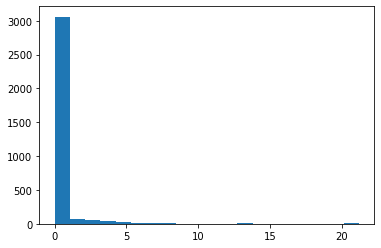

In [8]:
diseased_train_df = train_df.loc[train_df['disease_id'] != diseases.index('control')]
print('train df has the following diseases:')
print(diseased_train_df.disease.unique())
counts, bins, histplot = plt.hist(diseased_train_df[species].std(), bins=20)
select_species = np.array(species)[diseased_train_df[species].std().values>1.]
print(f"number of total species are: {len(species)}")
print(f"number of selected species are: {select_species.size}")

select_species_id = np.append(select_species, ['disease_id'])
train_df = train_df.loc[:,select_species_id]
train_df['id'] = np.arange(train_df.shape[0])
test_df = test_df.loc[:,select_species_id]
test_df['id'] = np.arange(test_df.shape[0])

# Implementing MAML with a multi-layer perceptron

We will now use few-shot learning to learn to predict the labels for these diseases. Our aim will be to distinguish a diseased microbiome sample for any given disease from a healthy, i.e. control sample given only a few labeled examples. 

We will use the technique of [Model Agnostic Meta-Learning by Finn et al](https://arxiv.org/abs/1703.03400) to learn to classify new diseases given only a few examples and closely follow the excellent [MAML implementation by Oscar Knagg](https://github.com/oscarknagg/few-shot).

In [9]:
### taken from Oscar Knagg's implementation ###

class NShotTaskSampler(data.Sampler):
    def __init__(self,
                 dataset: torch.utils.data.Dataset,
                 episodes_per_epoch: int = None,
                 n: int = None,
                 k: int = None,
                 q: int = None,
                 num_tasks: int = 1):
        """PyTorch Sampler subclass that generates batches of n-shot, k-way, 
        q-query tasks.

        Each n-shot task contains a "support set" of `k` sets of `n` samples and 
        a "query set" of `k` sets of `q` samples. The support set and the query set 
        are all grouped into one Tensor such that the first n * k samples are from 
        the support set while the remaining q * k samples are from the query set.

        The support and query sets are sampled such that they are disjoint 
        i.e. do not contain overlapping samples.

        # Arguments
            dataset: Instance of torch.utils.data.Dataset from which to draw samples
            episodes_per_epoch: Arbitrary number of batches of n-shot tasks to 
                                generate in one epoch
            n_shot: int. Number of samples for each class in the n-shot 
                            classification tasks.
            k_way: int. Number of classes in the n-shot classification tasks.
            q_queries: int. Number query samples for each class in the n-shot 
                            classification tasks.
            num_tasks: Number of n-shot tasks to group into a single batch
        """
        super(NShotTaskSampler, self).__init__(dataset)
        self.episodes_per_epoch = episodes_per_epoch
        self.dataset = dataset
        if num_tasks < 1:
            raise ValueError('num_tasks must be > 1.')

        self.num_tasks = num_tasks
        # TODO: Raise errors if initialise badly
        self.k = k
        self.n = n
        self.q = q
        
    def __len__(self):
        return self.episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            batch = []

            for task in range(self.num_tasks):
                # Get random classes
                episode_classes = np.random.choice(
                    self.dataset.data_frame['disease_id'].unique(), size=self.k, 
                                            replace=False)

                df = self.dataset.data_frame[
                        self.dataset.data_frame['disease_id'].isin(episode_classes)]

                support_k = {k: None for k in episode_classes}
                for k in episode_classes:
                    # Select support examples
                    support = df[df['disease_id'] == k].sample(self.n)
                    support_k[k] = support

                    for i, s in support.iterrows():
                        batch.append(s['id'])

                for k in episode_classes:
                    query = df[(df['disease_id'] == k) & (
                        ~df['id'].isin(support_k[k]['id']))].sample(self.q)
                    for i, q in query.iterrows():
                        batch.append(q['id'])

            yield np.stack(batch)
            

class SpeciesAbundanceDataset(data.Dataset):
    """Species Abundance dataset."""

    def __init__(self, abundance_df, species_columns, target_column):
        """
        Args:
        """
        self.data_frame = abundance_df
        self.species_cols = species_columns
        self.target_col = target_column
        
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            target = self.data_frame[self.target_col].iloc[idx].to_numpy(dtype='int')
        elif type(idx) != int:
            idx = int(idx)
            target = self.data_frame[self.target_col].iloc[idx]

        species_abundance = self.data_frame[self.species_cols].iloc[idx].to_numpy(
                                                                    dtype='float32')
        sample = (species_abundance, target)

        return sample

We will now create a multilayer perceptron to classify diseases from the microbiome metagenomics data, using [this notebook](https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb#scrollTo=CHadwpvmREvE) as our guide.

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, layer_size: int = 128):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, layer_size)
        self.output_fc = nn.Linear(layer_size, output_dim)

    def forward(self, x):

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        y_pred = self.output_fc(h_1)

        return y_pred
    
    
    def functional_forward(self, x, weights):
        """Applies the same forward pass using PyTorch functional 
        operators using a specified set of weights."""

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = F.linear(x, weights['input_fc.weight'], weights['input_fc.bias'])
        x = F.relu(x)
        x = F.linear(x, weights['output_fc.weight'], weights['output_fc.bias'])

        return x

We now write the Model Agnostic Meta-Learning gradient step function, closely following [this implementation](https://github.com/oscarknagg/few-shot).

In [11]:
def create_nshot_task_label(k: int, q: int) -> torch.Tensor:
    """Creates an n-shot task label.

    Label has the structure:
        [0]*q + [1]*q + ... + [k-1]*q

    # Arguments
        k: Number of classes in the n-shot classification task
        q: Number of query samples for each class in the n-shot classification task

    # Returns
        y: Label vector for n-shot task of shape [q * k, ]
    """
    y = torch.arange(0, k, 1 / q).long()

    return y

def prepare_meta_batch(n, k, q, meta_batch_size):
    def prepare_meta_batch_(batch):
        x, y = batch
        # Reshape to `meta_batch_size` number of tasks. Each task contains
        # n*k support samples to train the fast model on and q*k query samples to
        # evaluate the fast model on and generate meta-gradients
        x = x.reshape(meta_batch_size, n*k + q*k, x.shape[-1])
        # Move to device
        x = x.double().to(device)
        # Create label
        y = create_nshot_task_label(k, q).to(device).repeat(meta_batch_size)
        return x, y

    return prepare_meta_batch_


def replace_grad(parameter_gradients, parameter_name):
    def replace_grad_(module):
        return parameter_gradients[parameter_name]

    return replace_grad_

def meta_gradient_step(model: nn.Module,
                       optimizer: optim.Optimizer,
                       loss_fn: Callable,
                       x: torch.Tensor,
                       y: torch.Tensor,
                       n_shot: int,
                       k_way: int,
                       q_queries: int,
                       order: int,
                       inner_train_steps: int,
                       inner_lr: float,
                       train: bool,
                       device: Union[str, torch.device]):
    """
    Perform a gradient step on a meta-learner.

    # Arguments
        model: Base model of the meta-learner being trained
        optimizer: Optimizer to calculate gradient step from loss
        loss_fn: Loss function to calculate between predictions and outputs
        x: Input samples for all few shot tasks
        y: Input labels of all few shot tasks
        n_shot: Number of examples per class in the support set of each task
        k_way: Number of classes in the few shot classification task of each task
        q_queries: Number of examples per class in the query set of each task.
        The query set is used to calculate
            meta-gradients after applying the update to
        order: Whether to use 1st order MAML 
        (update meta-learner weights with gradients of the updated weights on the
            query set) or 2nd order MAML (use 2nd order updates by differentiating 
            through the gradients of the updated weights on the query with respect 
            to the original weights).
        inner_train_steps: Number of gradient steps to fit the fast weights 
                            during each inner update
        inner_lr: Learning rate used to update the fast weights on the inner update
        train: Whether to update the meta-learner weights at the end of the episode.
        device: Device on which to run computation
    """
    data_shape = x.shape[2:]
    create_graph = (True if order == 2 else False) and train

    task_gradients = []
    task_losses = []
    task_predictions = []
    for meta_batch in x:
        # By construction x is a 5D tensor of shape: 
        # (meta_batch_size, n*k + q*k, channels, width, height)
        # Hence when we iterate over the first  dimension 
        # we are iterating through the meta batches
        x_task_train = meta_batch[:n_shot * k_way]
        x_task_val = meta_batch[n_shot * k_way:]

        # Create a fast model using the current meta model weights
        fast_weights = OrderedDict(model.named_parameters())

        # Train the model for `inner_train_steps` iterations
        for inner_batch in range(inner_train_steps):
            # Perform update of model weights
            y = create_nshot_task_label(k_way,n_shot).to(device)
            y_pred = model.functional_forward(x_task_train, fast_weights)
            loss = loss_fn(y_pred, y)
            gradients = torch.autograd.grad(loss, fast_weights.values(), 
                                            create_graph=create_graph)

            # Update weights manually
            fast_weights = OrderedDict(
                (name, param - inner_lr * grad)
                for ((name, param), grad) in zip(fast_weights.items(), gradients))

        # Do a pass of the model on the validation data from the current task
        y = create_nshot_task_label(k_way,q_queries).to(device)
        y_pred = model.functional_forward(x_task_val, fast_weights)
        loss = loss_fn(y_pred, y)
        loss.backward(retain_graph=True)

        # Get post-update accuracies
        y_prob = y_pred.softmax(dim=1)
        task_predictions.append(y_prob)

        # Accumulate losses and gradients
        task_losses.append(loss)
        gradients = torch.autograd.grad(loss, fast_weights.values(), 
                                        create_graph=create_graph)
        named_grads = {name: g for ((name, _), g) in zip(fast_weights.items(), 
                                                         gradients)}
        task_gradients.append(named_grads)

    if order == 1:
        if train:
            sum_task_gradients = {k: torch.stack(
                [grad[k] for grad in task_gradients]).mean(dim=0)
                                  for k in task_gradients[0].keys()}
            hooks = []
            for name, param in model.named_parameters():
                hooks.append(
                    param.register_hook(replace_grad(sum_task_gradients, name))
                )

            model.train()
            optimizer.zero_grad()
            # Dummy pass in order to create `loss` variable
            # Replace dummy gradients with mean task gradients using hooks
            y_pred = model(torch.zeros((k_way, ) + data_shape).to(device, 
                                                              dtype=torch.double))
            loss = loss_fn(y_pred, create_nshot_task_label(k_way, 1).to(device))
            loss.backward()
            optimizer.step()

            for h in hooks:
                h.remove()

        return torch.stack(task_losses).mean(), torch.cat(task_predictions)

    elif order == 2:
        model.train()
        optimizer.zero_grad()
        meta_batch_loss = torch.stack(task_losses).mean()

        if train:
            meta_batch_loss.backward()
            optimizer.step()

        return meta_batch_loss, torch.cat(task_predictions)
    else:
        raise ValueError('Order must be either 1 or 2.')

Writing a few utility functions for evaluating model performance.

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(y_pred, y):
    return torch.eq(y_pred.argmax(dim=-1), y).sum().item() / y_pred.shape[0]

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We now write the train and evaluate functions which we will then call for each epoch.

In [13]:
def train(model: nn.Module, 
            taskloader: data.DataLoader, 
            optimizer: optim.Optimizer, 
            loss_fn: Callable, 
            prepare_batch: Callable, 
            **kwargs):
    seen = 0
    total_loss = 0
    total_acc = 0

    for batch_index, batch in enumerate(taskloader):
        x, y = prepare_batch(batch)

        loss, y_pred = meta_gradient_step(
            model,
            optimizer,
            loss_fn,
            x,
            y,
            **kwargs)

        seen += y_pred.shape[0]

        total_loss += loss.item() * y_pred.shape[0]
        total_acc += calculate_accuracy(y_pred, y) * y_pred.shape[0]

    total_loss = total_loss/seen
    total_acc = total_acc/seen
    return total_loss, total_acc

def evaluate(model: nn.Module, 
            taskloader: data.DataLoader, 
            optimizer: optim.Optimizer, 
            loss_fn: Callable, 
            prepare_batch: Callable, 
            **kwargs):
    seen = 0
    total_loss = 0
    total_acc = 0
    for batch_index, batch in enumerate(taskloader):
        x, y = prepare_batch(batch)

        loss, y_pred = meta_gradient_step(
            model,
            optimizer,
            loss_fn,
            x,
            y,
            **kwargs)

        seen += y_pred.shape[0]

        total_loss += loss.item()* y_pred.shape[0]
        total_acc += calculate_accuracy(y_pred, y) * y_pred.shape[0]

    total_loss = total_loss/seen
    total_acc = total_acc/seen
    return total_loss, total_acc

We will now construct the dataloader, set the hyperparameters for the algorithm, and for training and testing.

In [14]:
### 3-shot, 2-way classification ###
n_shot = 3
k_way = 2
q_queries = n_shot
meta_batch_size = 2

INPUT_DIM = len(select_species)
OUTPUT_DIM = k_way
LAYER_SIZE = 128
inner_lr = 0.01
meta_lr = 0.001
epoch_len = 800
epochs = 50
first_order_epochs = int(0.2*epochs)
second_order_epochs = epochs - first_order_epochs
eval_batches = 80
inner_train_steps = 5
inner_val_steps = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
meta_model = MLP(INPUT_DIM, OUTPUT_DIM, LAYER_SIZE).to(device, dtype=torch.double)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=meta_lr)
loss_fn = nn.CrossEntropyLoss().to(device)

print(f'The model has {count_parameters(meta_model):,} trainable parameters')

train_dataset = SpeciesAbundanceDataset(train_df, select_species, 'disease_id')
test_dataset = SpeciesAbundanceDataset(test_df, select_species, 'disease_id')

train_taskloader = data.DataLoader(
    train_dataset,
    batch_sampler=NShotTaskSampler(train_dataset, epoch_len, n=n_shot, 
                                   k=k_way, q=q_queries,
                                   num_tasks=meta_batch_size),
    num_workers=1
)

test_taskloader = data.DataLoader(
    test_dataset,
    batch_sampler=NShotTaskSampler(test_dataset, eval_batches, n=n_shot, 
                                   k=k_way, q=q_queries,
                                   num_tasks=meta_batch_size),
    num_workers=1
)


train_kwargs = {'n_shot':n_shot, 'k_way': k_way, 'q_queries': q_queries,
                'inner_train_steps': inner_train_steps, 'inner_lr': inner_lr,
                'order': 1, 'train': True, 'device': device} 

test_kwargs = {'n_shot':n_shot, 'k_way': k_way, 'q_queries': q_queries,
                'inner_train_steps': inner_val_steps, 'inner_lr': inner_lr,
                'order': 1, 'train': True, 'device': device}

The model has 33,026 trainable parameters


In [15]:
best_valid_loss = float('inf')
for epoch in trange(first_order_epochs):
    start_time = time.monotonic()

    train_loss, train_acc = train(meta_model, 
                                  train_taskloader, 
                                  meta_optimizer, 
                                  loss_fn, 
                                  prepare_meta_batch(n_shot, k_way, q_queries, 
                                                    meta_batch_size),
                                  **train_kwargs
                                 )
    
    valid_loss, valid_acc = evaluate(meta_model, 
                                  test_taskloader, 
                                  meta_optimizer, 
                                  loss_fn, 
                                  prepare_meta_batch(n_shot, k_way, q_queries, 
                                                    meta_batch_size),
                                  **test_kwargs
                                 )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(meta_model.state_dict(),'MLP-classifier.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02}/{first_order_epochs} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f}| Best Val. Loss:'
          f'{best_valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

for epoch in trange(second_order_epochs):
    start_time = time.monotonic()

    train_kwargs['order'] = 2
    train_loss, train_acc = train(meta_model, 
                                  train_taskloader, 
                                  meta_optimizer, 
                                  loss_fn, 
                                  prepare_meta_batch(n_shot, k_way, q_queries, 
                                                    meta_batch_size),
                                  **train_kwargs
                                 )

    test_kwargs['order'] = 2    
    valid_loss, valid_acc = evaluate(meta_model, 
                                  test_taskloader, 
                                  meta_optimizer, 
                                  loss_fn, 
                                  prepare_meta_batch(n_shot, k_way, q_queries, 
                                                    meta_batch_size),
                                  **test_kwargs
                                 )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(meta_model.state_dict(),'MLP-classifier.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02}/{second_order_epochs} | Epoch Time: '
          f'{epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f}| Best Val. Loss: '
          f'{best_valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 01/10 | Epoch Time: 0m 57s
	Train Loss: 0.423 | Train Acc: 82.57%
	 Val. Loss: 0.544| Best Val. Loss:0.544 |  Val. Acc: 74.69%
Epoch: 02/10 | Epoch Time: 0m 58s
	Train Loss: 0.242 | Train Acc: 90.56%
	 Val. Loss: 0.485| Best Val. Loss:0.485 |  Val. Acc: 78.23%
Epoch: 03/10 | Epoch Time: 0m 58s
	Train Loss: 0.233 | Train Acc: 91.99%
	 Val. Loss: 0.390| Best Val. Loss:0.390 |  Val. Acc: 83.12%
Epoch: 04/10 | Epoch Time: 0m 58s
	Train Loss: 0.197 | Train Acc: 92.93%
	 Val. Loss: 0.353| Best Val. Loss:0.353 |  Val. Acc: 85.62%
Epoch: 05/10 | Epoch Time: 0m 58s
	Train Loss: 0.170 | Train Acc: 94.20%
	 Val. Loss: 0.378| Best Val. Loss:0.353 |  Val. Acc: 84.17%
Epoch: 06/10 | Epoch Time: 0m 58s
	Train Loss: 0.186 | Train Acc: 93.96%
	 Val. Loss: 0.354| Best Val. Loss:0.353 |  Val. Acc: 85.83%
Epoch: 07/10 | Epoch Time: 0m 59s
	Train Loss: 0.156 | Train Acc: 94.80%
	 Val. Loss: 0.326| Best Val. Loss:0.326 |  Val. Acc: 86.46%
Epoch: 08/10 | Epoch Time: 0m 58s
	Train Loss: 0.172 | Train A

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01/40 | Epoch Time: 1m 2s
	Train Loss: 0.166 | Train Acc: 94.77%
	 Val. Loss: 0.378| Best Val. Loss: 0.310 |  Val. Acc: 84.17%
Epoch: 02/40 | Epoch Time: 1m 2s
	Train Loss: 0.140 | Train Acc: 95.97%
	 Val. Loss: 0.341| Best Val. Loss: 0.310 |  Val. Acc: 85.42%
Epoch: 03/40 | Epoch Time: 1m 1s
	Train Loss: 0.126 | Train Acc: 96.33%
	 Val. Loss: 0.315| Best Val. Loss: 0.310 |  Val. Acc: 88.12%
Epoch: 04/40 | Epoch Time: 1m 2s
	Train Loss: 0.124 | Train Acc: 95.98%
	 Val. Loss: 0.322| Best Val. Loss: 0.310 |  Val. Acc: 86.15%
Epoch: 05/40 | Epoch Time: 1m 2s
	Train Loss: 0.119 | Train Acc: 96.97%
	 Val. Loss: 0.283| Best Val. Loss: 0.283 |  Val. Acc: 87.08%
Epoch: 06/40 | Epoch Time: 1m 1s
	Train Loss: 0.135 | Train Acc: 96.12%
	 Val. Loss: 0.322| Best Val. Loss: 0.283 |  Val. Acc: 85.42%
Epoch: 07/40 | Epoch Time: 1m 2s
	Train Loss: 0.106 | Train Acc: 97.06%
	 Val. Loss: 0.299| Best Val. Loss: 0.283 |  Val. Acc: 86.88%
Epoch: 08/40 | Epoch Time: 1m 2s
	Train Loss: 0.122 | Train Ac

Writing functions for calculating different performance metrics. 

In [16]:
def calculate_metrics(y_pred, y):
    ### calculate confusion matrix, f1_score, roc_auc score
    pred_labels = y_pred.argmax(dim=-1).cpu()
    true_labels = y.cpu()
    cm = metrics.confusion_matrix(true_labels, pred_labels)
    f1_score = metrics.f1_score(true_labels, pred_labels)
    roc_auc_score = metrics.roc_auc_score(true_labels, pred_labels)
    return cm, f1_score, roc_auc_score

def evaluate_metrics(model: nn.Module, 
            taskloader: data.DataLoader, 
            optimizer: optim.Optimizer, 
            loss_fn: Callable, 
            prepare_batch: Callable, 
            **kwargs):
    seen = 0
    total_loss = 0
    total_acc = 0
    
    for batch_index, batch in enumerate(taskloader):
        x, y = prepare_batch(batch)

        loss, y_pred = meta_gradient_step(
            model,
            optimizer,
            loss_fn,
            x,
            y,
            **kwargs)

        seen += y_pred.shape[0]

        total_loss += loss.item()* y_pred.shape[0]
        total_acc += calculate_accuracy(y_pred, y) * y_pred.shape[0]
        if batch_index == 0:
            total_cm, avg_f1_score, avg_roc_auc_score = calculate_metrics(y_pred,
                                                                             y)
        else:
            cm, f1_score, roc_auc_score = calculate_metrics(y_pred, y)
            total_cm += cm
            avg_f1_score += f1_score
            avg_roc_auc_score += roc_auc_score
        
    total_loss = total_loss/seen
    total_acc = total_acc/seen
    avg_f1_score = avg_f1_score/batch_index
    avg_roc_auc_score = avg_roc_auc_score/batch_index
    return total_loss, total_acc, total_cm, avg_f1_score, avg_roc_auc_score

Loading the model parameters with the best validation loss, and calculating different performance metrics for it. 

In [17]:
meta_model.load_state_dict(torch.load('MLP-classifier.pt'))

test_kwargs['order'] = 2    
eval_loss, eval_acc, eval_cm, eval_f1, eval_roc_auc = evaluate_metrics(
                                meta_model, 
                                test_taskloader, 
                                meta_optimizer, 
                                loss_fn, 
                                prepare_meta_batch(n_shot, k_way, q_queries, 
                                                            meta_batch_size),
                                **test_kwargs)

print(f'Val. Loss: {valid_loss:.3f}| Best Val. Loss: '
      f'{best_valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
print(f'Val. F1 score: {eval_f1} | Val. ROC AUC score: {eval_roc_auc}')
print(f'Confusion matrix:')
print(eval_cm)

Val. Loss: 0.173| Best Val. Loss: 0.169 |  Val. Acc: 93.75%
Val. F1 score: 0.9700164814088859 | Val. ROC AUC score: 0.9694092827004219
Confusion matrix:
[[457  23]
 [ 18 462]]
